In [1]:
import sys
sys.path.append('..')

In [2]:
# Deep Learning
import torch
from torch import nn

# Data Utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess
from models import spot, networks

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

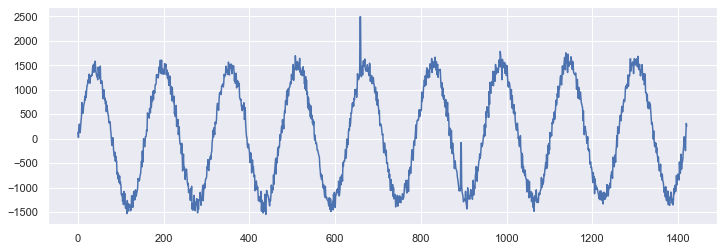

In [3]:
synth = pd.read_csv('data/synthetic_10.txt')
synth_tensor = torch.tensor(synth.value)
sns.lineplot(data=synth_tensor);

## Preprocess to Dataset/DataLoaders

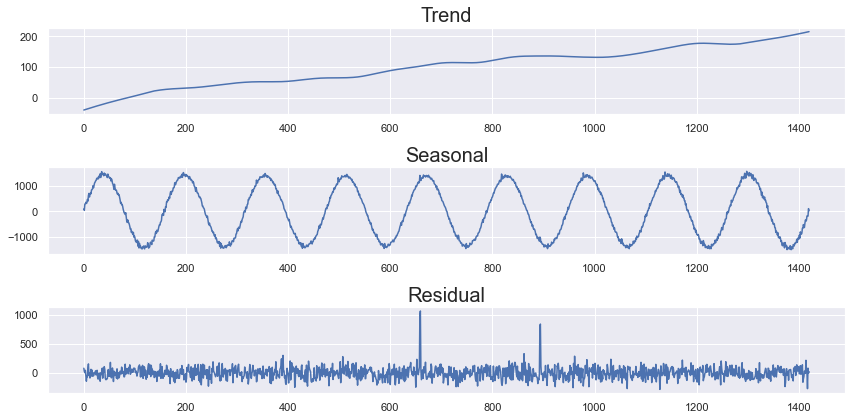

In [4]:
decomp = STL(synth.value, period=160, seasonal=13).fit()

fig, ax = plt.subplots(3,1, figsize=(12,6))
decomp.trend.plot(title='Trend', ax=ax[0])
decomp.seasonal.plot(title='Seasonal', ax=ax[1])
decomp.resid.plot(title='Residual', ax=ax[2])
plt.tight_layout()
plt.show()

residuals = torch.tensor(decomp.resid)

In [5]:
window = 7
n_features = 1
factor = 10
emb_size = window * n_features * factor

seqs = preprocess.sequence(residuals, window)
# transform = preprocess.Difference()
train_data = data.SimpleDataset(seqs, transform=None)
train_loader = DataLoader(train_data, shuffle=True)

## Initialize and Train New Model

In [6]:
model = networks.LSTMEncoderDecoder(n_features, emb_size)

In [7]:
criterion = nn.MSELoss(reduction='sum')
lr = 1e-4
loss = networks.train_encoder(model, 
                             epochs=300, 
                             lr=lr, 
                             criterion=criterion,
                             trainload=train_loader)

Training model on cpu


  0%|          | 0/300 [00:00<?, ?it/s]

## Visualize Loss

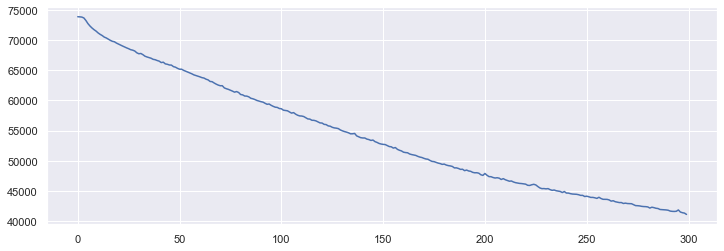

In [8]:
sns.lineplot(data=loss[0]);

In [9]:
torch.save(model.state_dict(), f'models/lstm_model_size={emb_size}_lr={lr}.pt')

# Visualize Reconstruction

In [10]:
# Get a random sample:
sample = seqs[30]

# apply difference transform
# sample = transform(sample)

# add dimensions for batch size and # features
sample = sample.unsqueeze(0).unsqueeze(-1).float()

out = model(sample)

In [11]:
# invert difference transform
# sample = transform.inverse(sample.squeeze())
# out = transform.inverse(out.squeeze())

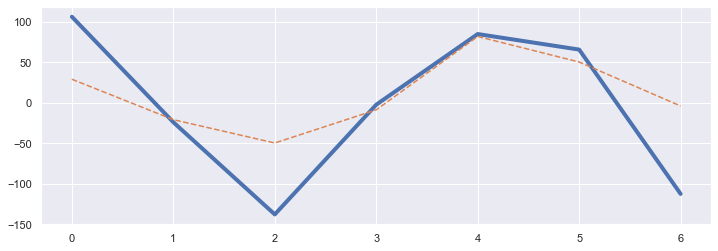

In [12]:
# plot original and reconstruction
plt.plot(sample.detach().numpy().squeeze(), '-', linewidth=4, label='Input')
plt.plot(out.detach().numpy().squeeze(), '--', label='Reconstructed');

## Run Inference on Data

In [13]:
# Run inference on all data.
reconstructed = torch.tensor([])
for seq in train_data:
    x = seq.unsqueeze(0).unsqueeze(-1).float()
    with torch.no_grad():
        x_hat = model(x)
        reconstructed = torch.cat((reconstructed, x_hat))
    

In [14]:
reconstructed = reconstructed.squeeze()

# # Invert difference transform
# reconstructed = [transform.inverse(seq) for seq in reconstructed]

# Concatenate sub-sequences
reconstructed = torch.cat(tuple(reconstructed))

## Compute Anomaly Scores

In [15]:
# Get L1 Loss of whole data set.
criterion = nn.L1Loss(reduction='none')
loss = criterion(reconstructed, residuals);

In [16]:
# Build cumulative density function from loss
cdf = ECDF(loss.squeeze())

# Get threshold
thresh = next(x for x in loss if cdf(x) > 0.99)

# get x, y coordinates for plotting anoms.
x = np.where(loss > thresh)[0]
y = loss[loss > thresh]

## Visualize Anomalies (without SPOT)

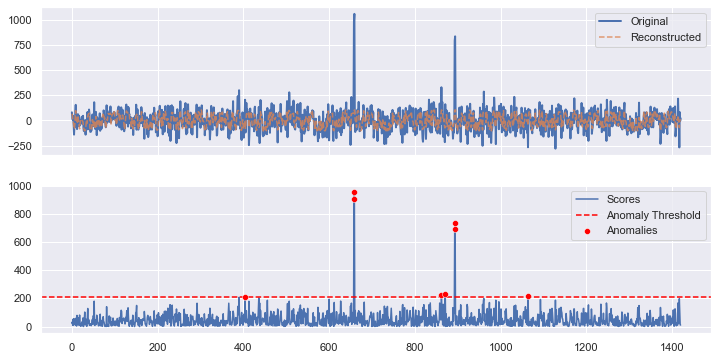

In [17]:
fig, ax, = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Reconstruction
sns.lineplot(data=residuals, linestyle='-', linewidth=2, ax=ax[0], label="Original")
sns.lineplot(data=reconstructed, linestyle='--', alpha=0.8, ax=ax[0], label='Reconstructed')

# Anomaly detection
sns.lineplot(data=loss, label='Scores', ax=ax[1])
sns.scatterplot(x=x, y=y, color='red', ax=ax[1], label='Anomalies', zorder=3)
ax[1].axhline(y=thresh, c='red', linestyle='--', label='Anomaly Threshold')

plt.legend(loc='upper right')
plt.show()

## Visualize Anomalies with SPOT:

Initial threshold : 155.69643691627866
Number of peaks : 11
Grimshaw maximum log-likelihood estimation ... bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 0.17719858581243883
bounds1 0.6080921540912237
step 0.039172142570798624
[done]
	γ = 0
	σ = 27.446028136595498
	L = 47.43443609309778
Extreme quantile (probability = 0.0001): 298.72608773410735


  0%|          | 0/821 [00:00<?, ?it/s]

bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 0.1796080899343262
bounds1 0.6374381589950591
step 0.04162091536915753
bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 0.17711821576085804
bounds1 0.6071467144320879
step 0.039093499879202714
bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 0.1767724624775766
bounds1 0.6031030635176914
step 0.03875732736728316
bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 0.17369895275499658
bounds1 0.5687671341443218
step 0.035915289217211384
bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 0.17217413531361123
bounds1 0.5527381258018338
step 0.03459672640802023
bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 2.671681024222325
bounds1 89.06877073087563
step 7.854280882423027
bounds0 -0.017453840109539022
bounds1 -1e-08
step 0.001586711828139911
bounds0 2.6693978044378683
b

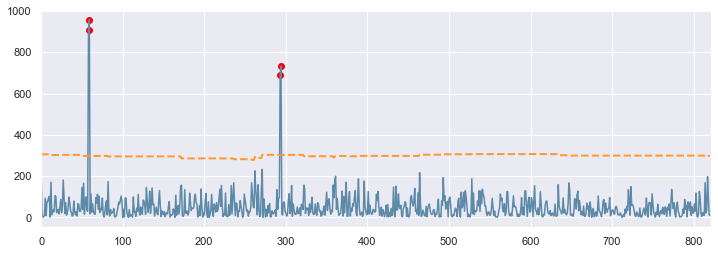

In [18]:
from models import spot

# Split data for initialization step
init_data = loss[:600].numpy()
run_data = loss[600:].numpy()

# Risk threshold (probability)
q = 1e-4

# Initialize
sp = spot.SPOT()
sp.fit(init_data, run_data)
sp.initialize(level=0.98) 

# P(X > t) < level 
# P(X > t) > P(X > x_q), 
# looking for z_q s.t. P(X > z_q) < q

# Run
results = sp.run()

# Plot
fig = sp.plot(results);